**ChessMe => 
getting files from kaggle
containing chess various positions over multiple chess boards.**

In [ ]:
**DOWNLOAD DATASET**
import numpy as np 
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


**IMPORTING DEPENDENCIES**

In [48]:
import random as rd
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

**PREPARING DATA CHUNK**

In [17]:
train_path = glob.glob("../input/chess-positions/train/*.jpeg")
test_path = glob.glob("../input/chess-positions/test/*.jpeg")

rd.shuffle(train_path)
rd.shuffle(test_path)

train_sample_size = 2000
test_sample_size = 100

train = train_path[:train_sample_size]
test = test_path[:test_sample_size]



**Removing Identical Positions**

In [35]:
train = list(set(train))
test = list(set(test))

In [40]:
print(len(train))
print(len(test))

2000
100


**Function for FEN Extractioin**

In [36]:
def get_fen_label(img_path):
    label = img_path.replace(".jpeg","").split("/")[-1]
    return label

**For Each Element we extracting FEN**

In [37]:
train_label = list(map(lambda x : get_fen_label(x),train))
test_label = list(map(lambda x: get_fen_label(x),test))

**Displaying Test IMAGE**

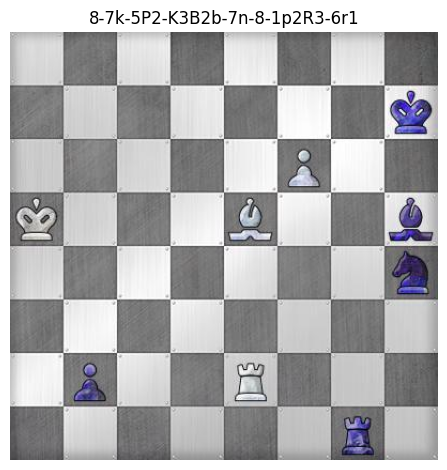

In [38]:
test_index = rd.randint(0,train_sample_size)
img=cv2.imread(train[test_index])
plt.imshow(img)
plt.title(train_label[test_index])
plt.axis('off')
plt.tight_layout()
plt.show()

**Displaying GRID of boards**

/tmp/ipykernel_32/1911641042.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


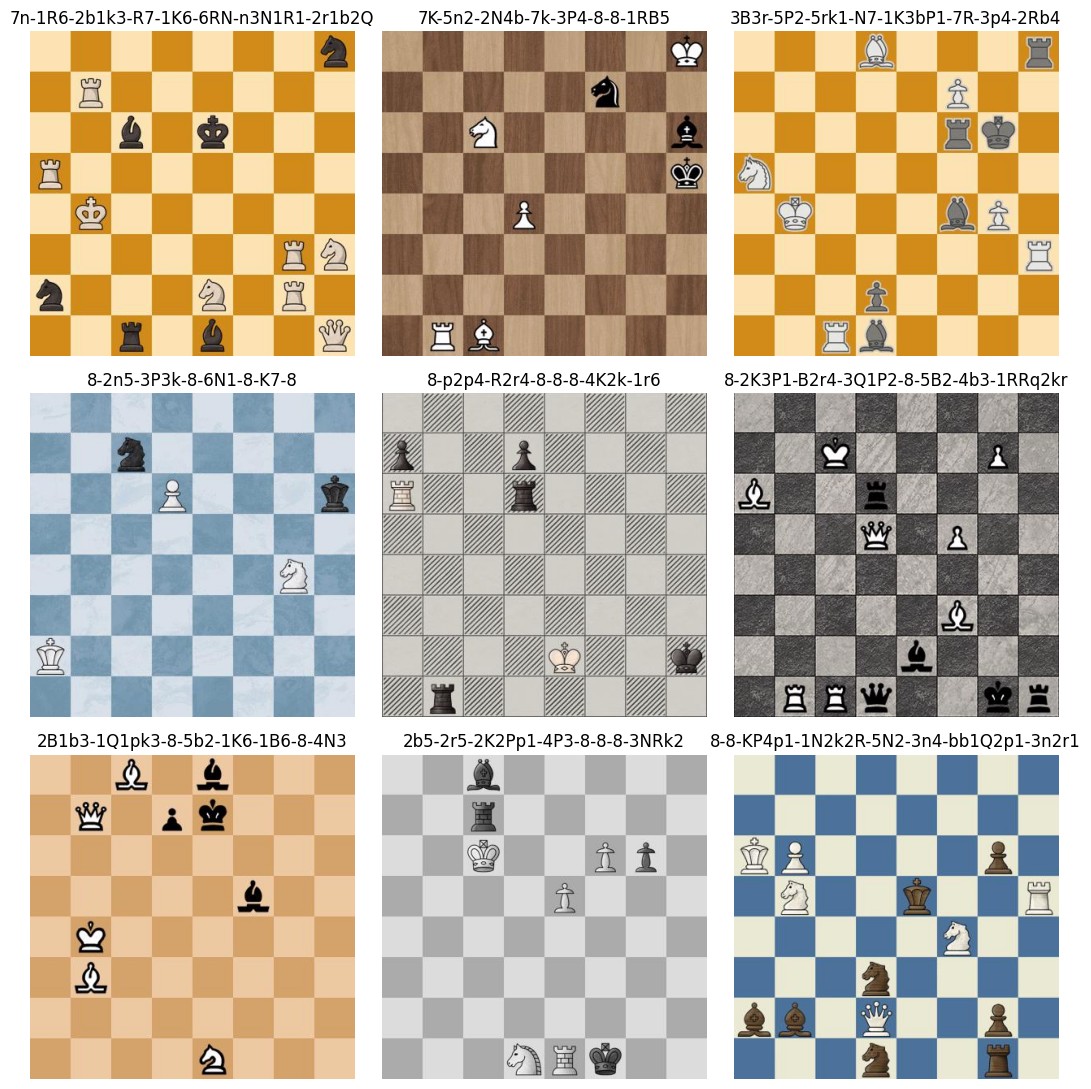

In [39]:
dim = 3
samples = rd.sample(train,dim*dim)
grid_tile = plt.figure(figsize=(11,11))


for i, img in zip(range(1, dim*dim +1),samples ):
    grid_tile.add_subplot(dim, dim, i)
    fen_label =  get_fen_label(img)
    img = cv2.imread(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(fen_label)
    plt.tight_layout()
    
plt.show()

****

**Correcting Image Dimensions**

In [44]:
dimensions = []
for img_path in train:
    img = cv2.imread(img_path)
    dimensions.append([img.shape[0],img.shape[1]])
    
print(dimensions[:5])

[[400, 400], [400, 400], [400, 400], [400, 400], [400, 400]]


Text(0.5, 1.0, 'Average Height : 400')

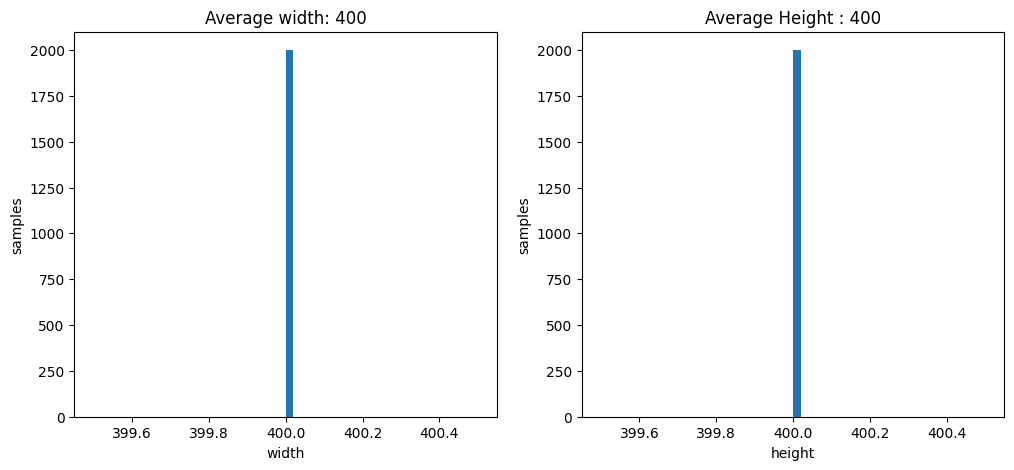

In [58]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))

width = int(np.mean(list(map(lambda x: x[0],dimensions))))
ax1.hist(list(map(lambda x: x[0],dimensions)), bins=50)
ax1.set_xlabel('width')
ax1.set_ylabel('samples')
ax1.set_title('Average width: {}'.format(width))

height = int(np.mean(list(map(lambda x: x[0],dimensions))))
ax2.hist(list(map(lambda x : x[1],dimensions)),bins=50)
ax2.set_xlabel('height')
ax2.set_ylabel('samples')
ax2.set_title('Average Height : {}'.format(height))


**ON basis of above EDA we will write function to get perfect sample**
* img -> grayscale
* grayscale -> resized
* resized -> normalized

In [59]:
def preprocess_data(raw_data):
    processed_data = []
    for img in raw_data:
        grayscale_img = cv2.imread(img,cv2.COLOR_BGR2GRAY)
        resized_img = cv2.resize(grayscale_img,(width,height))
        normalized_img = (resized_img - np.min(resized_img) / np.max(resized_img) - np.min(resized_img))
        processed_data.append(normalized_img)
    return processed_data

In [61]:
print(np.eye(3))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [67]:
print(np.empty((0, 3)))

[]


/tmp/ipykernel_32/1927610512.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


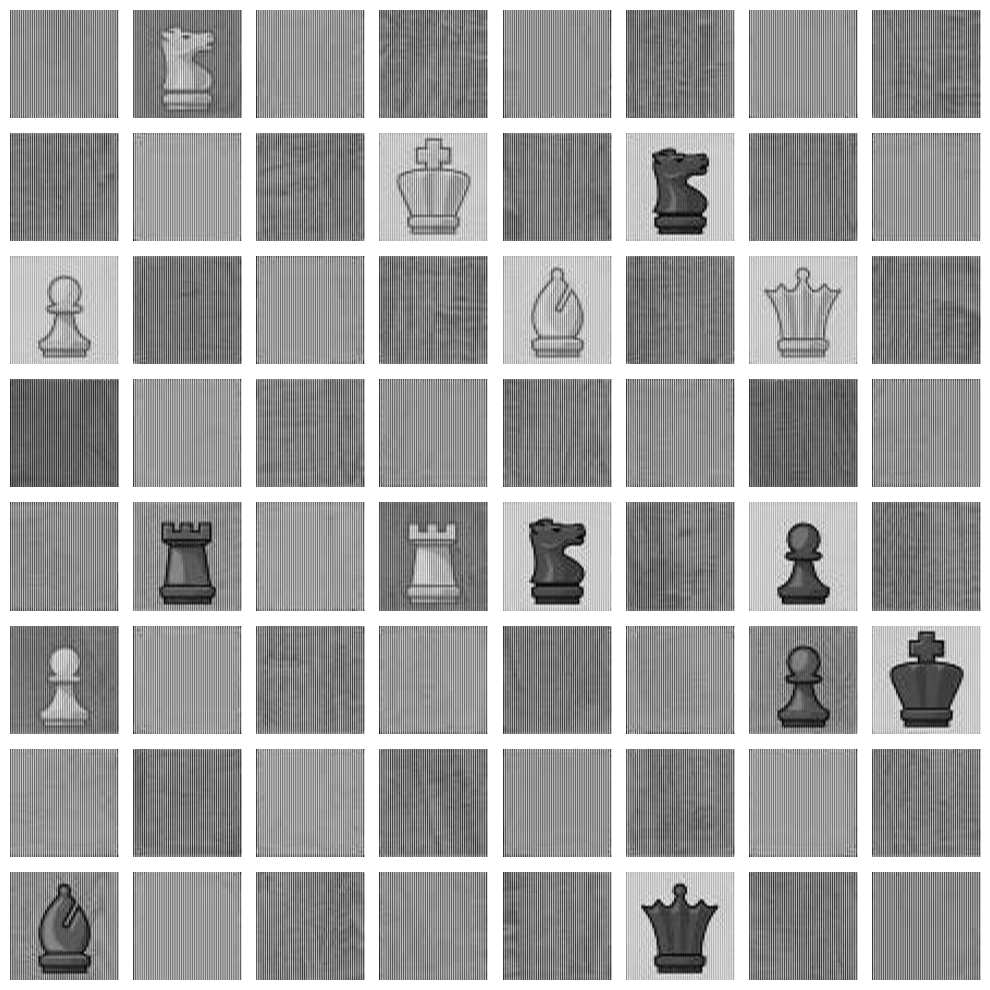

(64, 720, 720)

In [68]:
def image_to_squares_pca(img,heights,widths):
  squares = []
  for i in range(0,8):
    for j in range(0,8):
      new_img =img[i*heights//8:i*heights//8+heights//8,j*widths//8:j*widths//8+widths//8]
      new_img=new_img.reshape(new_img.shape[0], (new_img.shape[1]*new_img.shape[2]))
      new_img= cv2.resize(new_img, (720, 720),interpolation=cv2.INTER_CUBIC)
      squares.append(new_img)
  return np.array(squares)

img = np.array(cv2.imread(train[8]))
sqaures= image_to_squares_pca(img,400,400)
fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1),sqaures):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()
sqaures.shape


**ENCODER AND DECODER**

In [ ]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [ ]:


def train_gen(features):
    for i, img in enumerate(features):
        y = onehot_from_fen(get_image_FEN_label(img))
        x = preprocess_image(img)
        yield x, y

def pred_gen(features):
    for i, img in enumerate(features):
        y = onehot_from_fen(get_image_FEN_label(img))
        x = preprocess_image(img)
        yield x, y



In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# Add a convolutional layer
model = Sequential()
model.add(Convolution2D(32, (3, 3),activation='relu', input_shape=(30, 30, 3)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Convolution2D(16, (5, 5),activation='relu'))
model.add(Flatten())
model.add(Dropout(0.35))
model.add(Dense(13, activation='softmax'))
model.summary()

In [ ]:


# Compile the model 
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])



In [ ]:
# Fit parameters
EPOCHS=100

print("\nTraining Progress:\n------------------------")
hist = model.fit_generator(train_gen(train), steps_per_epoch=train_size//EPOCHS, epochs=EPOCHS,
                           validation_data=pred_gen(test), validation_steps=test_size//EPOCHS)

In [ ]:


#- Save Model
model.save('../working/models/chess_model.h5')



In [ ]:
import matplotlib.image as mpimg
def display_with_predicted_fen(image):
    plt.figure(figsize=(5,5))
    pred = model.predict(preprocess_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()
    return fen

In [ ]:


predicted_fen=display_with_predicted_fen(test[230])
print("predicted FEN :",predicted_fen)
board = chess.Board(predicted_fen.replace('-', '/'))
chess.svg.board(board, size=300)  

